# Library import and data loading

In [221]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
import scipy.sparse as sp
from scipy import stats
from libreco.data import random_split, DatasetPure, split_by_ratio_chrono
from libreco.algorithms import LightGCN
from libreco.evaluation import evaluate

In [222]:
df = pd.read_csv(#"C:\\Users\\marci\\OneDrive\\Pulpit\\archive\\interactions.csv",
                 "C:\\Users\\fpazi\\Desktop\\projekty\\olx\\interactions.csv",
                 sep=',')

# EDA

## Basic statistics

In [223]:
df['event'].value_counts()

event
click                    58817263
contact_phone_click_1     1721338
bookmark                  1644602
chat_click                1399051
contact_chat               948470
contact_partner_click      459305
contact_phone_click_2      444497
contact_phone_click_3       67675
Name: count, dtype: int64

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65502201 entries, 0 to 65502200
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 2.0+ GB


In [225]:
n_users = df['user'].nunique()
n_items = df['item'].nunique()

print('Number of users: ', n_users)
print('Number of items: ', n_items)

Number of users:  3295942
Number of items:  185395


In [226]:
n_events_per_user = df.groupby('user').size()
n_events_per_item = df.groupby('item').size()

print('Average number of events per user: ', round(np.mean(n_events_per_user), 2), ' with a standard deviation of ', np.std(n_events_per_user))
print('Average number of events per item: ', round(np.mean(n_events_per_item), 2), ' with a standard deviation of ', np.std(n_events_per_item))

Average number of events per user:  19.87  with a standard deviation of  47.762363188402105
Average number of events per item:  353.31  with a standard deviation of  624.7732106025969


In [227]:
print('Median number of events per user: ', round(np.median(n_events_per_user), 2))
print('Median number of events per item: ', round(np.median(n_events_per_item), 2))

Median number of events per user:  6.0
Median number of events per item:  137.0


## Number of interactions per user

In [228]:
n_events_per_user.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
dtype: float64

Text(0.5, 1.0, 'ECDF of interactions per user.')

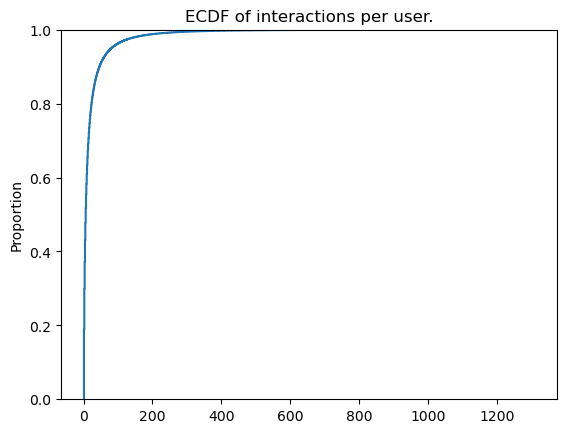

In [229]:
sns.ecdfplot(n_events_per_user).set_title("ECDF of interactions per user.")

Text(0.5, 1.0, 'Histogram of log(interactions) per item.')

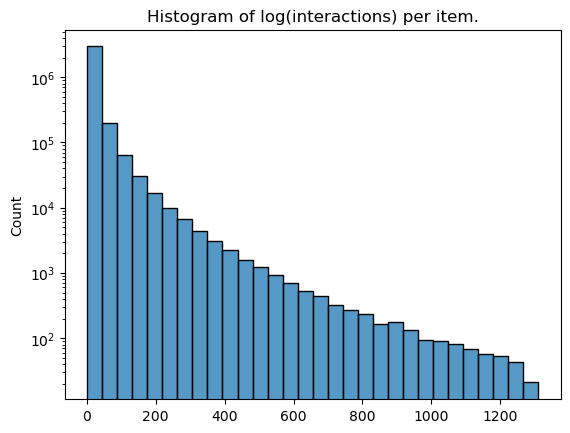

In [230]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1.set_title("Histogram of log(interactions) per item.")

Logarithmic scale :D events vs users/items

Text(0.5, 1.0, 'Boxplot of interactions per user.')

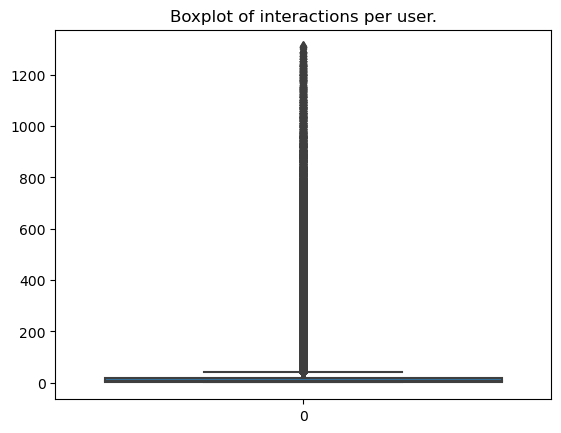

In [231]:
sns.boxplot(n_events_per_user).set_title("Boxplot of interactions per user.")

Text(0.5, 1.0, 'Boxplot of log(interactions) per user.')

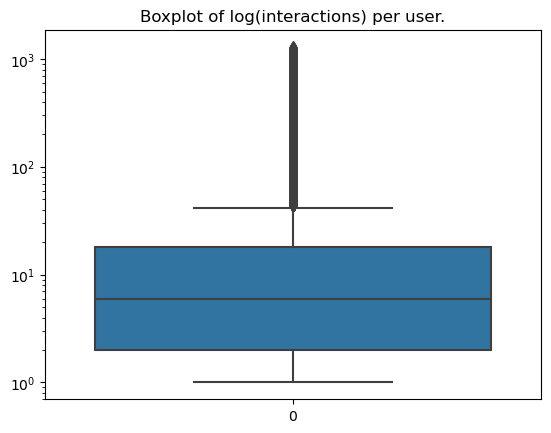

In [232]:
h = sns.boxplot(n_events_per_user)
h.set_yscale('log')
h.set_title("Boxplot of log(interactions) per user.")

## Number of interactions per item

In [233]:
n_events_per_item.describe()

count    185395.000000
mean        353.311583
std         624.774896
min           1.000000
25%           3.000000
50%         137.000000
75%         428.000000
max       15480.000000
dtype: float64

Text(0.5, 1.0, 'ECDF of interactions per plot.')

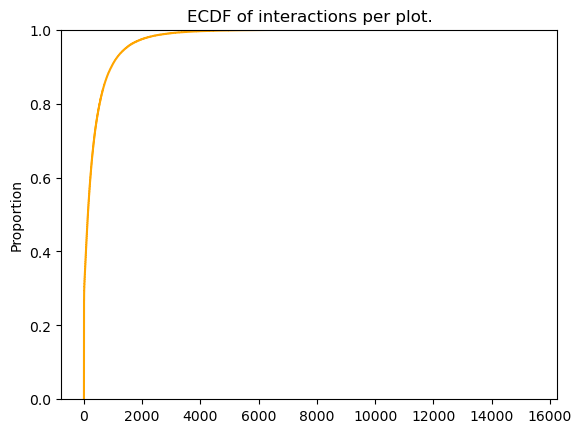

In [234]:
sns.ecdfplot(n_events_per_item, color='orange').set_title('ECDF of interactions per item.')

<Axes: title={'center': 'Histogram of log(interactions) per item.'}, ylabel='Count'>

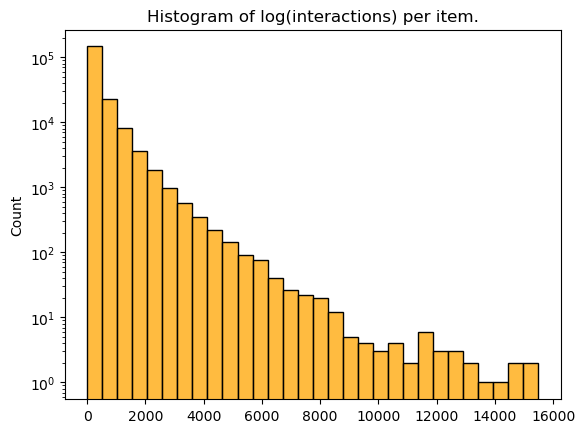

In [235]:
h2 = sns.histplot(n_events_per_item, bins=30, color='orange')
h2.set_yscale("log")
h2.set_title("Histogram of log(interactions) per item.")
h2

Text(0.5, 1.0, 'Boxplot of interactions per item.')

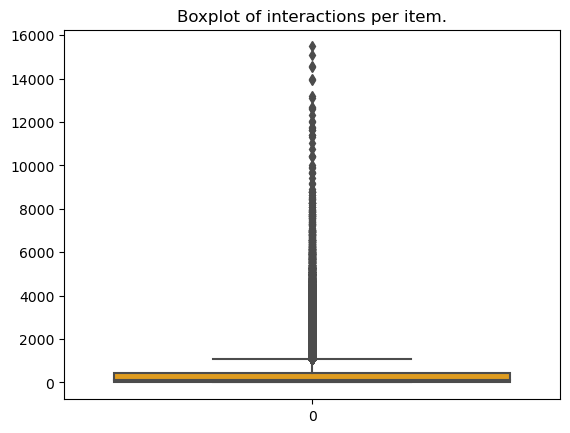

In [236]:
sns.boxplot(n_events_per_item, color='orange').set_title("Boxplot of interactions per item.")

<Axes: title={'center': 'Boxplot of log(interactions) per item.'}>

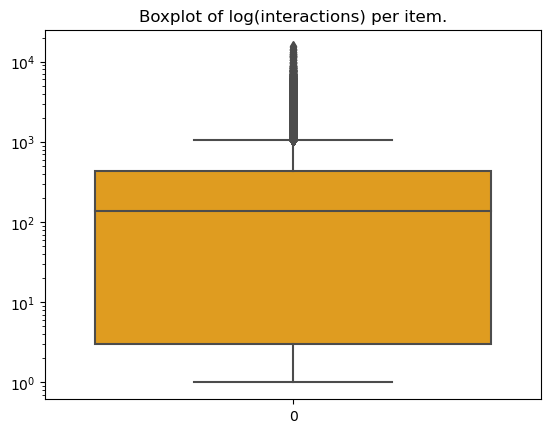

In [237]:
h4 = sns.boxplot(n_events_per_item, color='orange')
h4.set_yscale('log')
h4.set_title('Boxplot of log(interactions) per item.')
h4

# Data pre-processing

Split the values from the `event` column so that we can tailor our data frame to the task.

In [238]:
rating = {
    'click': 1,
    'bookmark': 2,
    'chat_click': 3,
    'contact_phone_click_1': 3,
    'contact_partner_click': 3,
    'contact_phone_click_2': 3,
    'contact_phone_click_3': 3,
    'contact_chat': 3
}
df['event'] = df['event'].map(rating)
df = df.rename(columns={'event': 'label'})
df = df.rename(columns={'timestamp': 'time'})

In [239]:
user_interaction_counts = df['user'].value_counts()
user_interaction_counts.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
Name: count, dtype: float64

We get rid of users with less than 100 interactions. In this way, we hope to weed out users who are not regulars. <br>We get rid of outliers using the 8 sigma method.

In [240]:
reg_users = user_interaction_counts[user_interaction_counts >= 100]
users_to_keep = reg_users[reg_users <= reg_users.mean() + 8*reg_users.std()].index
df = df[df['user'].isin(users_to_keep)]

In [241]:
n_events_per_user = df.groupby('user').size()
n_events_per_user.describe()

count    123531.000000
mean        202.475403
std         134.874360
min         100.000000
25%         121.000000
50%         156.000000
75%         229.000000
max        1283.000000
dtype: float64

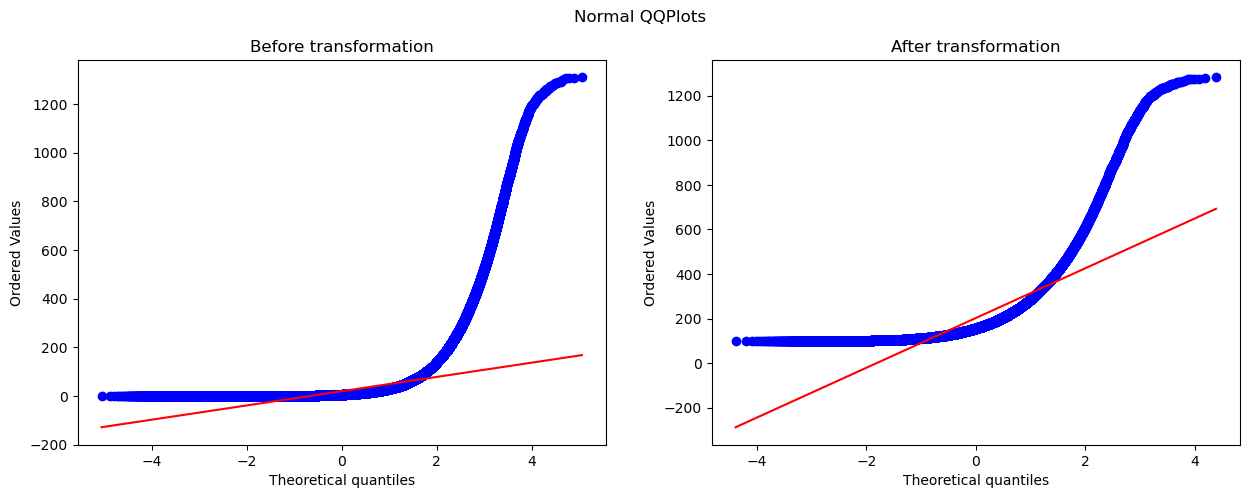

In [242]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))
stats.probplot(user_interaction_counts, dist='norm', plot=axis[0])
axis[0].set_title("Before transformation")

stats.probplot(n_events_per_user, dist='norm', plot=axis[1])
axis[1].set_title("After transformation")

figure.suptitle("Normal QQPlots")
plt.show()

<Axes: title={'center': 'Histogram of log(interactions) per user.'}, ylabel='Count'>

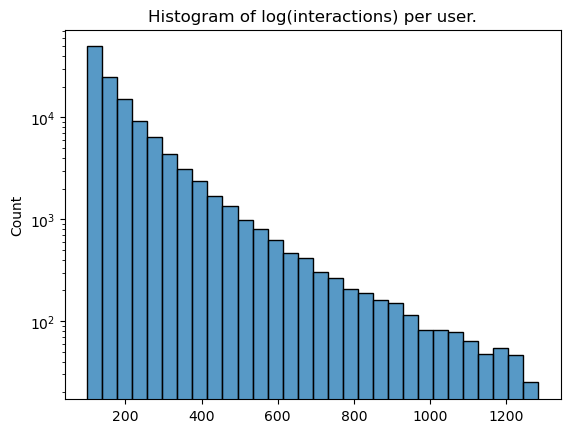

In [243]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1.set_title('Histogram of log(interactions) per user.')
h1

Text(0.5, 1.0, 'Boxplot of interactions per user.')

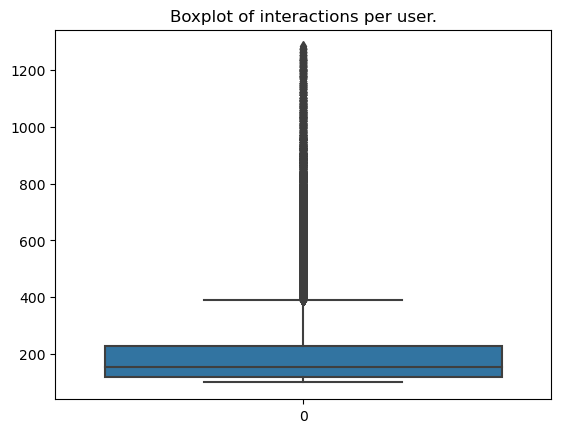

In [244]:
sns.boxplot(n_events_per_user.values).set_title('Boxplot of interactions per user.')

<Axes: title={'center': 'Boxplot of log(number of interactions) per user.'}>

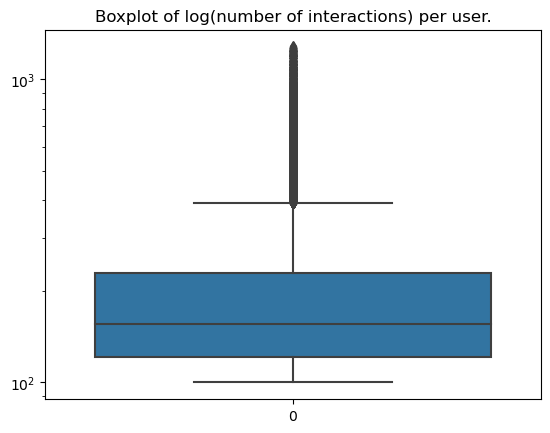

In [245]:
h = sns.boxplot(n_events_per_user.values)
h.set_yscale('log')
h.set_title('Boxplot of log(number of interactions) per user.')
h

We get rid of items with fewer than 1,000 interactions. In doing so, we hope to retain items that enjoy at least moderate success. <br>We get rid of outliers using the 8 sigma method.

In [246]:
item_interaction_counts = df['item'].value_counts()

In [247]:
item_interaction_counts.describe()

count    145085.000000
mean        172.395416
std         298.115472
min           1.000000
25%          23.000000
50%          74.000000
75%         195.000000
max        7276.000000
Name: count, dtype: float64

In [248]:
popular_item = item_interaction_counts[item_interaction_counts >= 1000]
items_to_keep = popular_item[popular_item <= popular_item.mean() + 8*popular_item.std()].index
df = df[df['item'].isin(items_to_keep)].reset_index(drop=True)

In [249]:
n_events_per_item = df.groupby('item').size()
n_events_per_item.describe()

count    3290.000000
mean     1577.923100
std       693.458523
min      1000.000000
25%      1139.000000
50%      1355.000000
75%      1754.000000
max      7080.000000
dtype: float64

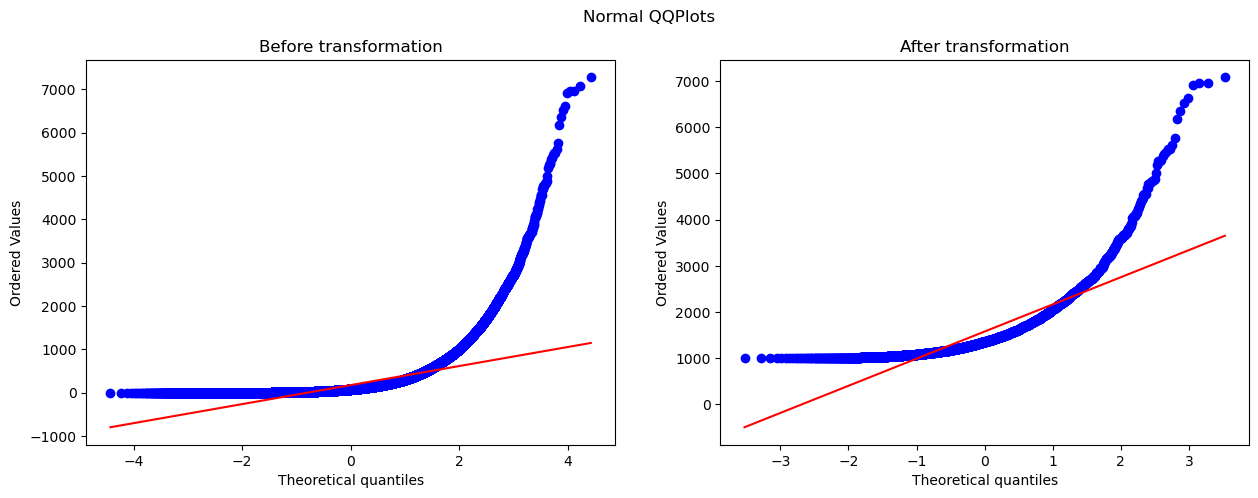

In [250]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))
stats.probplot(item_interaction_counts, dist='norm', plot=axis[0])
axis[0].set_title("Before transformation")

stats.probplot(n_events_per_item, dist='norm', plot=axis[1])
axis[1].set_title("After transformation")

figure.suptitle("Normal QQPlots")
plt.show()
# nie za bardzo umiem kolor zmienić więc zostawie tak

<Axes: title={'center': 'Histogram of log(interactions) per item.'}, ylabel='Count'>

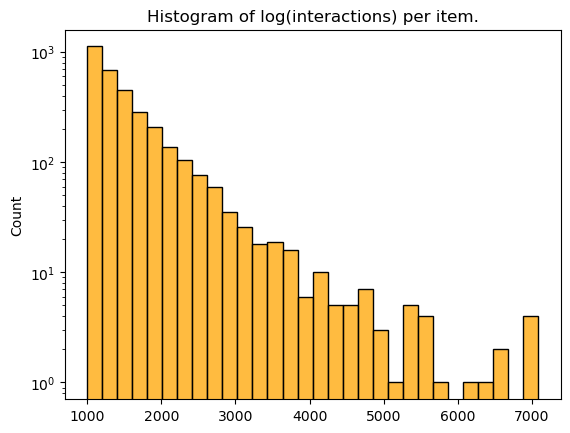

In [251]:
h2 = sns.histplot(n_events_per_item, bins=30, color='orange')
h2.set_yscale("log")
h2.set_title("Histogram of log(interactions) per item.")
h2

Text(0.5, 1.0, 'Boxplot of interactions per item.')

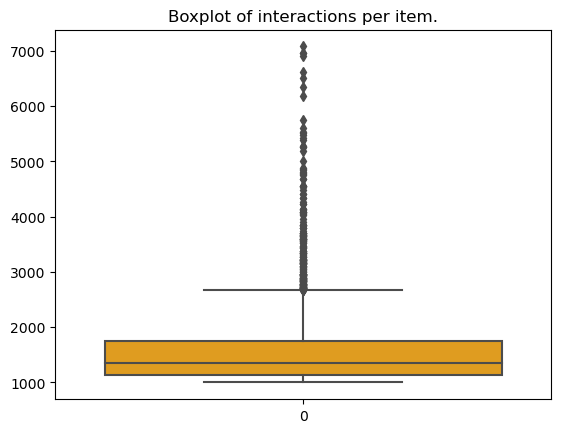

In [252]:
sns.boxplot(n_events_per_item.values, color='orange').set_title("Boxplot of interactions per item.")

<Axes: title={'center': 'Boxplot of log(number of interactions) per item.'}>

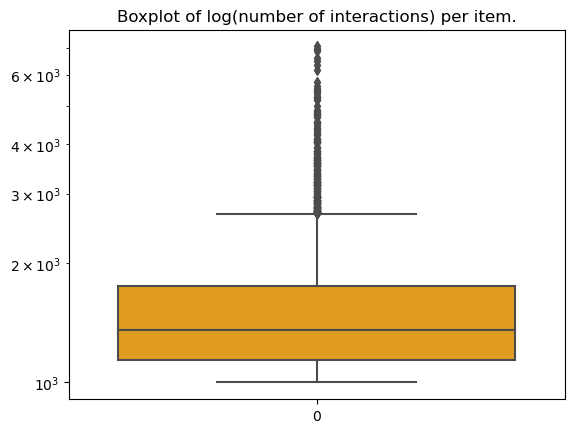

In [253]:
h4 = sns.boxplot(n_events_per_item.values, color='orange')
h4.set_yscale('log')
h4.set_title("Boxplot of log(number of interactions) per item.")
h4

 First filtering of the data frame. We select the 20% of users with the highest number of interactions.

In [254]:
user_interaction_counts = df['user'].value_counts()

top_20_threshold = user_interaction_counts.quantile(0.8)

top_20_users = user_interaction_counts[user_interaction_counts >= top_20_threshold].index

filtered_df = df[df['user'].isin(top_20_users)]

In [255]:
user_interaction_counts = filtered_df['user'].value_counts()

user_interaction_counts.describe()

count    25027.000000
mean       110.009030
std         60.541146
min         61.000000
25%         72.000000
50%         89.000000
75%        124.000000
max       1073.000000
Name: count, dtype: float64

We do the same for the items.

In [256]:
item_interaction_counts = df['item'].value_counts()

top_20_threshold = item_interaction_counts.quantile(0.8)

top_20_items = item_interaction_counts[item_interaction_counts >= top_20_threshold].index

filtered_df = filtered_df[filtered_df['item'].isin(top_20_items)]

In [257]:
item_interaction_counts = filtered_df['item'].value_counts()

item_interaction_counts.describe()

count     658.000000
mean     1560.200608
std       721.665109
min       191.000000
25%      1110.500000
50%      1428.000000
75%      1803.750000
max      5243.000000
Name: count, dtype: float64

We compare the ratio of items/users in the input data frame and the filtered one. As we can see, the ratio is almost identical.

In [258]:
count_users_before = df['user'].nunique()
count_items_before = df['item'].nunique()
count_users = filtered_df['user'].nunique()
print(f"Number of users: {count_users}")
count_items = filtered_df['item'].nunique()
print(f"Number of items: {count_items}")
print(f"Ratio of items to users after filtering: {count_items/count_users * 100}")
print(f"Ratio of items to users before filtering: {count_items_before/count_users_before * 100}")

Number of users: 25013
Number of items: 658
Ratio of items to users after filtering: 2.630632071322912
Ratio of items to users before filtering: 2.6687649053359075


Another filtering of the data frame.<br>
Now we randomly select $x\% $ of unique objects and users so that the machines we are working on do not have memory problems.

In [259]:
sample_percent = 1

sampled_users = filtered_df.drop_duplicates('user').sample(frac=sample_percent, random_state=2024)

sampled_items = filtered_df.drop_duplicates('item').sample(frac=sample_percent, random_state=2024)

filtered_df_users = filtered_df[filtered_df['user'].isin(sampled_users['user'])]

filtered_df = filtered_df_users[filtered_df_users['item'].isin(sampled_items['item'])]

Again, let's check the item/user ratio.

In [260]:
count_users = filtered_df['user'].nunique()
print(f"Number of users: {count_users}")
count_items = filtered_df['item'].nunique()
print(f"Number of items: {count_items}")
print(f"Ratio of items to users after filtering: {count_items/count_users * 100}")
print(f"Ratio of items to users before filtering: {count_items_before/count_users_before * 100}")

Number of users: 25013
Number of items: 658
Ratio of items to users after filtering: 2.630632071322912
Ratio of items to users before filtering: 2.6687649053359075


# Creating the model

We implement code from the LibRecommender library that divides the data into a training and evaluation set.

In [261]:
train_data, eval_data, test_data = random_split(filtered_df, multi_ratios=[0.7, 0.1, 0.2])
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 24995, n_items: 658, data density: 4.3694 %


In [262]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="bpr",
    embed_size=32,
    n_epochs=3,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

In [263]:
%%time
# można też spróbować %%timeit jeśli kod się będzie w miarę krótko wykonywał (liczy średnii czas wykonywania komórki) 
lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

Training start time: 2024-03-06 22:31:15


train: 100%|██████████| 351/351 [01:44<00:00,  3.35it/s]


Epoch 1 elapsed: 104.651s
	 train_loss: 0.4872


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 328.19it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:03<00:00, 550.17it/s]


	 eval log_loss: 0.5134
	 eval precision@10: 0.0276
	 eval recall@10: 0.0756
	 eval ndcg@10: 0.1216
	 eval map@10: 0.0866


train: 100%|██████████| 351/351 [01:44<00:00,  3.35it/s]


Epoch 2 elapsed: 104.835s
	 train_loss: 0.245


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 396.41it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1092.30it/s]


	 eval log_loss: 0.5095
	 eval precision@10: 0.0297
	 eval recall@10: 0.0829
	 eval ndcg@10: 0.1300
	 eval map@10: 0.0923


train: 100%|██████████| 351/351 [01:44<00:00,  3.36it/s]


Epoch 3 elapsed: 104.553s
	 train_loss: 0.2055


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 404.86it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:02<00:00, 742.17it/s]


	 eval log_loss: 0.5152
	 eval precision@10: 0.0309
	 eval recall@10: 0.0870
	 eval ndcg@10: 0.1354
	 eval map@10: 0.0962
CPU times: total: 3min 54s
Wall time: 5min 29s


Czemu eval log loss wzrasta??

In [264]:
%%time
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 382.80it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:02<00:00, 829.34it/s] 


CPU times: total: 2.44 s
Wall time: 5.04 s


{'loss': 0.5085316571395424,
 'roc_auc': 0.9144389753656805,
 'precision': 0.055034814121096134,
 'recall': 0.09209679036082377,
 'ndcg': 0.21685532435683655,
 'map': 0.1562613956422418}

In [265]:
%%time
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=5
)

eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 377.59it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:01<00:00, 1094.29it/s]


CPU times: total: 1.52 s
Wall time: 3.24 s


{'loss': 0.5085316571395424,
 'precision': 0.06620790748808991,
 'recall': 0.05613278991254196,
 'ndcg': 0.17925235534233724,
 'map': 0.1471096259155803}

In [266]:
%%time
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=2
)

eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 377.71it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:02<00:00, 757.75it/s] 


CPU times: total: 1.17 s
Wall time: 3.94 s


{'loss': 0.5085316571395424,
 'precision': 0.07856590252046093,
 'recall': 0.02704228790088742,
 'ndcg': 0.12527470118970233,
 'map': 0.1174111323750967}

In [267]:
%time
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=1
)

CPU times: total: 0 ns
Wall time: 0 ns


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 372.39it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:02<00:00, 854.07it/s] 


{'loss': 0.5085316571395424,
 'precision': 0.08738140803778656,
 'recall': 0.014958578169661342,
 'ndcg': 0.08738140803778656,
 'map': 0.08738140803778656}

Wszystko poniżej tego kawałka kodu to zabawy w zmianę funkcji straty, zmiana parametrów itd itp.

In [268]:
%%time
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=32,
    n_epochs=5,
    lr=0.001,
    batch_size=512,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

Training start time: 2024-03-06 22:37:00


train: 100%|██████████| 2808/2808 [13:47<00:00,  3.39it/s]


Epoch 1 elapsed: 827.795s
	 train_loss: 0.5143


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 380.99it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:02<00:00, 778.11it/s] 


	 eval log_loss: 0.4813
	 eval precision@10: 0.0296
	 eval recall@10: 0.0834
	 eval ndcg@10: 0.1302
	 eval map@10: 0.0924


train: 100%|██████████| 2808/2808 [13:54<00:00,  3.37it/s]


Epoch 2 elapsed: 834.317s
	 train_loss: 0.4753


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 379.54it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 983.10it/s] 


	 eval log_loss: 0.4705
	 eval precision@10: 0.0311
	 eval recall@10: 0.0894
	 eval ndcg@10: 0.1360
	 eval map@10: 0.0959


train: 100%|██████████| 2808/2808 [13:57<00:00,  3.35it/s]


Epoch 3 elapsed: 837.205s
	 train_loss: 0.4671


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 315.95it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 993.02it/s] 


	 eval log_loss: 0.4657
	 eval precision@10: 0.0322
	 eval recall@10: 0.0934
	 eval ndcg@10: 0.1407
	 eval map@10: 0.0994


train: 100%|██████████| 2808/2808 [13:59<00:00,  3.35it/s]


Epoch 4 elapsed: 839.377s
	 train_loss: 0.4628


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 377.10it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1068.18it/s]


	 eval log_loss: 0.4626
	 eval precision@10: 0.0334
	 eval recall@10: 0.0976
	 eval ndcg@10: 0.1468
	 eval map@10: 0.1042


train: 100%|██████████| 2808/2808 [13:58<00:00,  3.35it/s]


Epoch 5 elapsed: 838.268s
	 train_loss: 0.4586


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 384.87it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1063.46it/s]


	 eval log_loss: 0.4601
	 eval precision@10: 0.0349
	 eval recall@10: 0.1016
	 eval ndcg@10: 0.1531
	 eval map@10: 0.1092


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 370.04it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:02<00:00, 752.77it/s] 


CPU times: total: 54min 36s
Wall time: 1h 10min


{'loss': 0.45532217110094547,
 'roc_auc': 0.9328348860860025,
 'precision': 0.06223787613502178,
 'recall': 0.10652472455931809,
 'ndcg': 0.24444250877685156,
 'map': 0.17696106248172722}

In [269]:
%%time
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

Training start time: 2024-03-06 23:47:01


train: 100%|██████████| 702/702 [05:07<00:00,  2.28it/s]


Epoch 1 elapsed: 307.648s
	 train_loss: 0.4722


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 267.15it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1030.40it/s]


	 eval log_loss: 0.4599
	 eval precision@10: 0.0396
	 eval recall@10: 0.1140
	 eval ndcg@10: 0.1739
	 eval map@10: 0.1261


train: 100%|██████████| 702/702 [05:09<00:00,  2.27it/s]


Epoch 2 elapsed: 309.625s
	 train_loss: 0.4522


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 270.23it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1061.58it/s]


	 eval log_loss: 0.4567
	 eval precision@10: 0.0408
	 eval recall@10: 0.1164
	 eval ndcg@10: 0.1797
	 eval map@10: 0.1307


train: 100%|██████████| 702/702 [05:09<00:00,  2.27it/s]


Epoch 3 elapsed: 309.350s
	 train_loss: 0.4454


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 263.77it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1020.65it/s]


	 eval log_loss: 0.4556
	 eval precision@10: 0.0418
	 eval recall@10: 0.1188
	 eval ndcg@10: 0.1850
	 eval map@10: 0.1353


train: 100%|██████████| 702/702 [05:11<00:00,  2.26it/s]


Epoch 4 elapsed: 311.157s
	 train_loss: 0.4423


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 268.65it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 988.91it/s] 


	 eval log_loss: 0.4541
	 eval precision@10: 0.0427
	 eval recall@10: 0.1216
	 eval ndcg@10: 0.1899
	 eval map@10: 0.1394


train: 100%|██████████| 702/702 [05:12<00:00,  2.25it/s]


Epoch 5 elapsed: 312.194s
	 train_loss: 0.4384


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 261.31it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:02<00:00, 942.24it/s] 


	 eval log_loss: 0.4541
	 eval precision@10: 0.0428
	 eval recall@10: 0.1226
	 eval ndcg@10: 0.1915
	 eval map@10: 0.1413


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 251.58it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:01<00:00, 1037.80it/s]


CPU times: total: 23min 26s
Wall time: 26min 13s


{'loss': 0.44788791300669284,
 'roc_auc': 0.9390330609013593,
 'precision': 0.07438413616189585,
 'recall': 0.1264100297491425,
 'ndcg': 0.2918305995144644,
 'map': 0.21773034970147237}

In [270]:
%%time
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="focal",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

Training start time: 2024-03-07 00:13:14


train: 100%|██████████| 702/702 [05:14<00:00,  2.23it/s]


Epoch 1 elapsed: 314.461s
	 train_loss: 0.0779


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 225.77it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1042.63it/s]


	 eval log_loss: 0.5740
	 eval precision@10: 0.0365
	 eval recall@10: 0.1046
	 eval ndcg@10: 0.1625
	 eval map@10: 0.1187


train: 100%|██████████| 702/702 [05:15<00:00,  2.23it/s]


Epoch 2 elapsed: 315.215s
	 train_loss: 0.0772


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 253.37it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1039.80it/s]


	 eval log_loss: 0.5709
	 eval precision@10: 0.0342
	 eval recall@10: 0.0975
	 eval ndcg@10: 0.1557
	 eval map@10: 0.1148


train: 100%|██████████| 702/702 [05:16<00:00,  2.22it/s]


Epoch 3 elapsed: 316.660s
	 train_loss: 0.0768


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 261.40it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1022.69it/s]


	 eval log_loss: 0.5679
	 eval precision@10: 0.0322
	 eval recall@10: 0.0898
	 eval ndcg@10: 0.1482
	 eval map@10: 0.1098


train: 100%|██████████| 702/702 [05:15<00:00,  2.23it/s]


Epoch 4 elapsed: 315.477s
	 train_loss: 0.0764


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 255.86it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1073.76it/s]


	 eval log_loss: 0.5675
	 eval precision@10: 0.0306
	 eval recall@10: 0.0833
	 eval ndcg@10: 0.1417
	 eval map@10: 0.1050


train: 100%|██████████| 702/702 [05:15<00:00,  2.23it/s]


Epoch 5 elapsed: 315.209s
	 train_loss: 0.0759


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 253.49it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 987.84it/s] 


	 eval log_loss: 0.5679
	 eval precision@10: 0.0282
	 eval recall@10: 0.0755
	 eval ndcg@10: 0.1304
	 eval map@10: 0.0961


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 244.44it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:01<00:00, 1043.14it/s]


CPU times: total: 23min 52s
Wall time: 26min 40s


{'loss': 0.5671088056239247,
 'roc_auc': 0.9040885022196438,
 'precision': 0.04906958752392198,
 'recall': 0.07693297609571771,
 'ndcg': 0.20308084709124613,
 'map': 0.1508834532757206}

In [271]:
%%time
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="max_margin",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

Training start time: 2024-03-07 00:39:54


train: 100%|██████████| 351/351 [02:37<00:00,  2.23it/s]


Epoch 1 elapsed: 157.614s
	 train_loss: 0.1988


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 265.32it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1029.46it/s]


	 eval log_loss: 0.5087
	 eval precision@10: 0.0411
	 eval recall@10: 0.1178
	 eval ndcg@10: 0.1815
	 eval map@10: 0.1325


train: 100%|██████████| 351/351 [02:36<00:00,  2.24it/s]


Epoch 2 elapsed: 156.889s
	 train_loss: 0.1188


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 266.47it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:02<00:00, 859.70it/s]


	 eval log_loss: 0.5316
	 eval precision@10: 0.0424
	 eval recall@10: 0.1215
	 eval ndcg@10: 0.1872
	 eval map@10: 0.1371


train: 100%|██████████| 351/351 [02:36<00:00,  2.24it/s]


Epoch 3 elapsed: 156.708s
	 train_loss: 0.101


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 274.87it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:02<00:00, 827.79it/s]


	 eval log_loss: 0.5523
	 eval precision@10: 0.0431
	 eval recall@10: 0.1240
	 eval ndcg@10: 0.1919
	 eval map@10: 0.1412


train: 100%|██████████| 351/351 [02:36<00:00,  2.24it/s]


Epoch 4 elapsed: 156.789s
	 train_loss: 0.0903


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 267.85it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:02<00:00, 949.01it/s] 


	 eval log_loss: 0.5664
	 eval precision@10: 0.0436
	 eval recall@10: 0.1252
	 eval ndcg@10: 0.1947
	 eval map@10: 0.1440


train: 100%|██████████| 351/351 [02:36<00:00,  2.24it/s]


Epoch 5 elapsed: 156.651s
	 train_loss: 0.0829


eval_pointwise: 100%|██████████| 26/26 [00:00<00:00, 270.69it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 1930/1930 [00:01<00:00, 1049.53it/s]


	 eval log_loss: 0.5824
	 eval precision@10: 0.0435
	 eval recall@10: 0.1241
	 eval ndcg@10: 0.1941
	 eval map@10: 0.1435


eval_pointwise: 100%|██████████| 51/51 [00:00<00:00, 253.86it/s]
c:\Users\fpazi\anaconda3\envs\olx\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 2047/2047 [00:02<00:00, 939.17it/s]


CPU times: total: 11min 57s
Wall time: 13min 28s


{'loss': 0.5737806840855078,
 'roc_auc': 0.9385162951623347,
 'precision': 0.07564233071379128,
 'recall': 0.12860315847352116,
 'ndcg': 0.2955969373731411,
 'map': 0.22095432663388348}

# Additional task

dataframe containing users and an array of items they have interacted with

In [272]:

df_all = filtered_df.groupby('user')['item'].apply(list).reset_index(name='items')
df_all = df_all.sort_values(by='user')

a dataframe containing users and an array of items with which they have interacted at a higher level

In [273]:
df_23 = filtered_df[filtered_df['label'].isin([2, 3])].groupby('user')['item'].apply(list).reset_index(name='items')
all_users = filtered_df[['user']].drop_duplicates()
df_23 = pd.merge(all_users, df_23, on='user', how='left')
df_23['items'] = df_23['items'].apply(lambda x: x if isinstance(x, list) else [])
df_23 = df_23.sort_values(by='user')

a dataframe containing users and an array of items that are recommended to them

In [274]:
unique_users = filtered_df['user'].unique()
recommendations_data = []

recommendations for each user

In [275]:
for user in unique_users:
    recommendations = lightgcn.recommend_user(user=user, n_rec=10).get(user)
    recommendations_data.extend([(user, recommendations)])

df_rec = pd.DataFrame(recommendations_data, columns=['user', 'items'])
df_rec = df_rec.sort_values(by='user')


Detect unknown user: 2736520
Detect unknown user: 756207
Detect unknown user: 1168189
Detect unknown user: 527726
Detect unknown user: 2184051
Detect unknown user: 400733
Detect unknown user: 2046605
Detect unknown user: 1209362
Detect unknown user: 2198747
Detect unknown user: 1448084
Detect unknown user: 3205838
Detect unknown user: 317418
Detect unknown user: 1520618
Detect unknown user: 2103786
Detect unknown user: 100772
Detect unknown user: 3126654
Detect unknown user: 402521
Detect unknown user: 24794


In [276]:

def find_intersection(row, df):
    rec_items = row['items']
    all_items = df.loc[df['user'] == row['user'], 'items'].values
    if len(rec_items) == 0 or len(all_items) == 0:
        return []
    else:
        intersection = np.intersect1d(rec_items, all_items[0])
        return intersection


Restriction of recommended items to those with which the user has had any interaction

In [277]:
df_rec['items'] = df_rec.apply(lambda row: find_intersection(row, df_all), axis=1)

df_match = df_rec.copy()

Listing of items both recommended and those with which the user has had higher-level interaction

In [278]:
df_match['items'] = df_match.apply(lambda row: find_intersection(row, df_23), axis=1)

`precision`

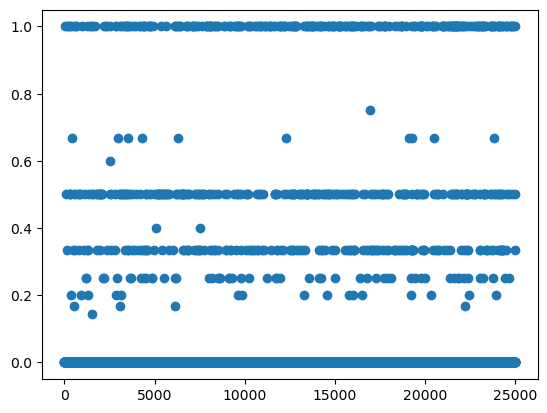

In [279]:
(df_match['items'].apply(len)/df_rec['items'].apply(len)).sum(skipna=True)/len(df_match['items']) 
matplotlib.pyplot.plot(df_match['items'].apply(len)/df_rec['items'].apply(len), 'o')

`recall`

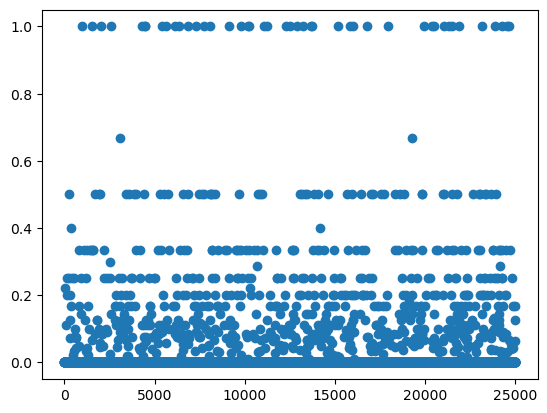

In [280]:
(df_match['items'].apply(len)/df_23['items'].apply(len)).sum(skipna=True)/len(df_match['items']) 
matplotlib.pyplot.plot(df_match['items'].apply(len)/df_23['items'].apply(len), 'o')